In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from tensorflow import keras
from tensorflow.keras import layers
import keras.backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD, Adam, Adagrad, RMSprop
from keras.utils.np_utils import to_categorical # Pretty Neat

### Exercise 1

You've just been hired at a wine company and they would like you to help them build a model that predicts the quality of their wine based on several measurements. They give you a dataset with wine

- Load the ../data/wines.csv into Pandas
- Use the column called "Class" as target
- Check how many classes are there in target, and if necessary use dummy columns for a multi-class classification
- Use all the other columns as features, check their range and distribution (using seaborn pairplot)
- Rescale all the features using either MinMaxScaler or StandardScaler
- Build a deep model with at least 1 hidden layer to classify the data
- Choose the cost function, what will you use? Mean Squared Error? Binary Cross-Entropy? Categorical Cross-Entropy?
- Choose an optimizer
- Choose a value for the learning rate, you may want to try with several values
- Choose a batch size
- Train your model on all the data using a `validation_split=0.2`. Can you converge to 100% validation accuracy?
- What's the minumum number of epochs to converge?
- Repeat the training several times to verify how stable your results are

In [2]:
wine_data = pd.read_csv('data/wines.csv')
wine_data.head()

,Class,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280-OD315_of_diluted_wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [3]:
wine_data['Class'].value_counts()

2    71
1    59
3    48
Name: Class, dtype: int64

In [4]:
pd.get_dummies(wine_data['Class'],prefix='class')

,class_1,class_2,class_3
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
173,0,0,1
174,0,0,1
175,0,0,1
176,0,0,1


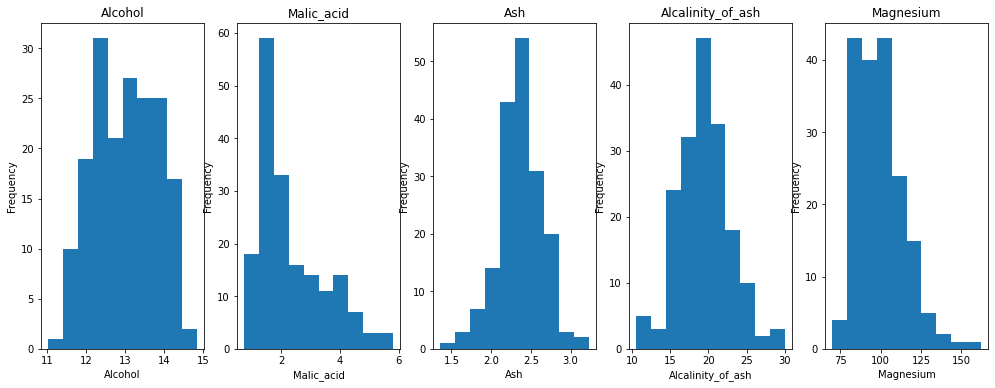

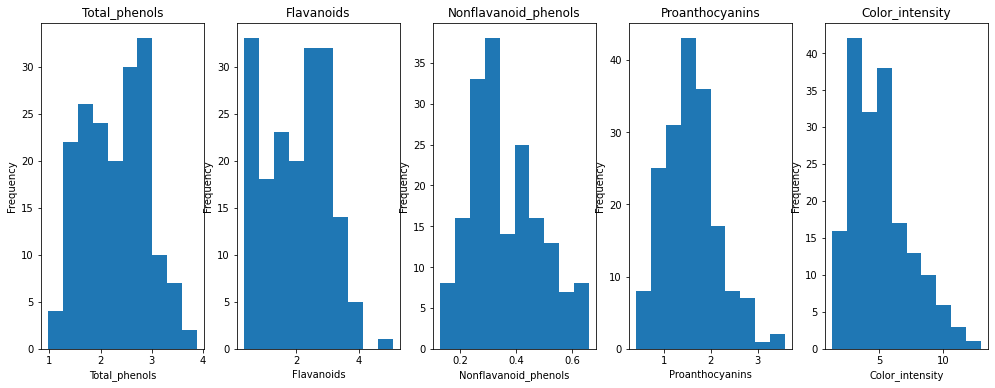

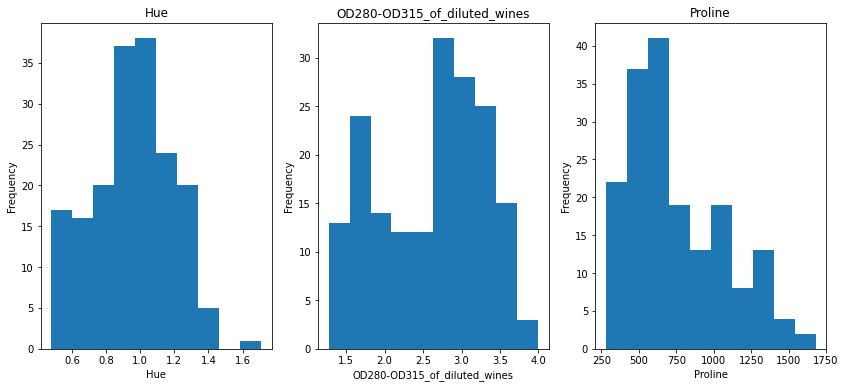

In [5]:
plt.figure(figsize=(24,6))
for i,feature in enumerate(wine_data.columns[1:6]):
    plt.subplot(1,7,i+1)
    wine_data[feature].plot(kind='hist',title=feature)
    plt.xlabel(feature)

plt.figure(figsize=(24,6))  
for i,feature in enumerate(wine_data.columns[6:11]):
    plt.subplot(1,7,i+1)
    wine_data[feature].plot(kind='hist',title=feature)
    plt.xlabel(feature)
    

plt.figure(figsize=(24,6))   
for i,feature in enumerate(wine_data.columns[11:14]):
    plt.subplot(1,5,i+1)
    wine_data[feature].plot(kind='hist',title=feature)
    plt.xlabel(feature)

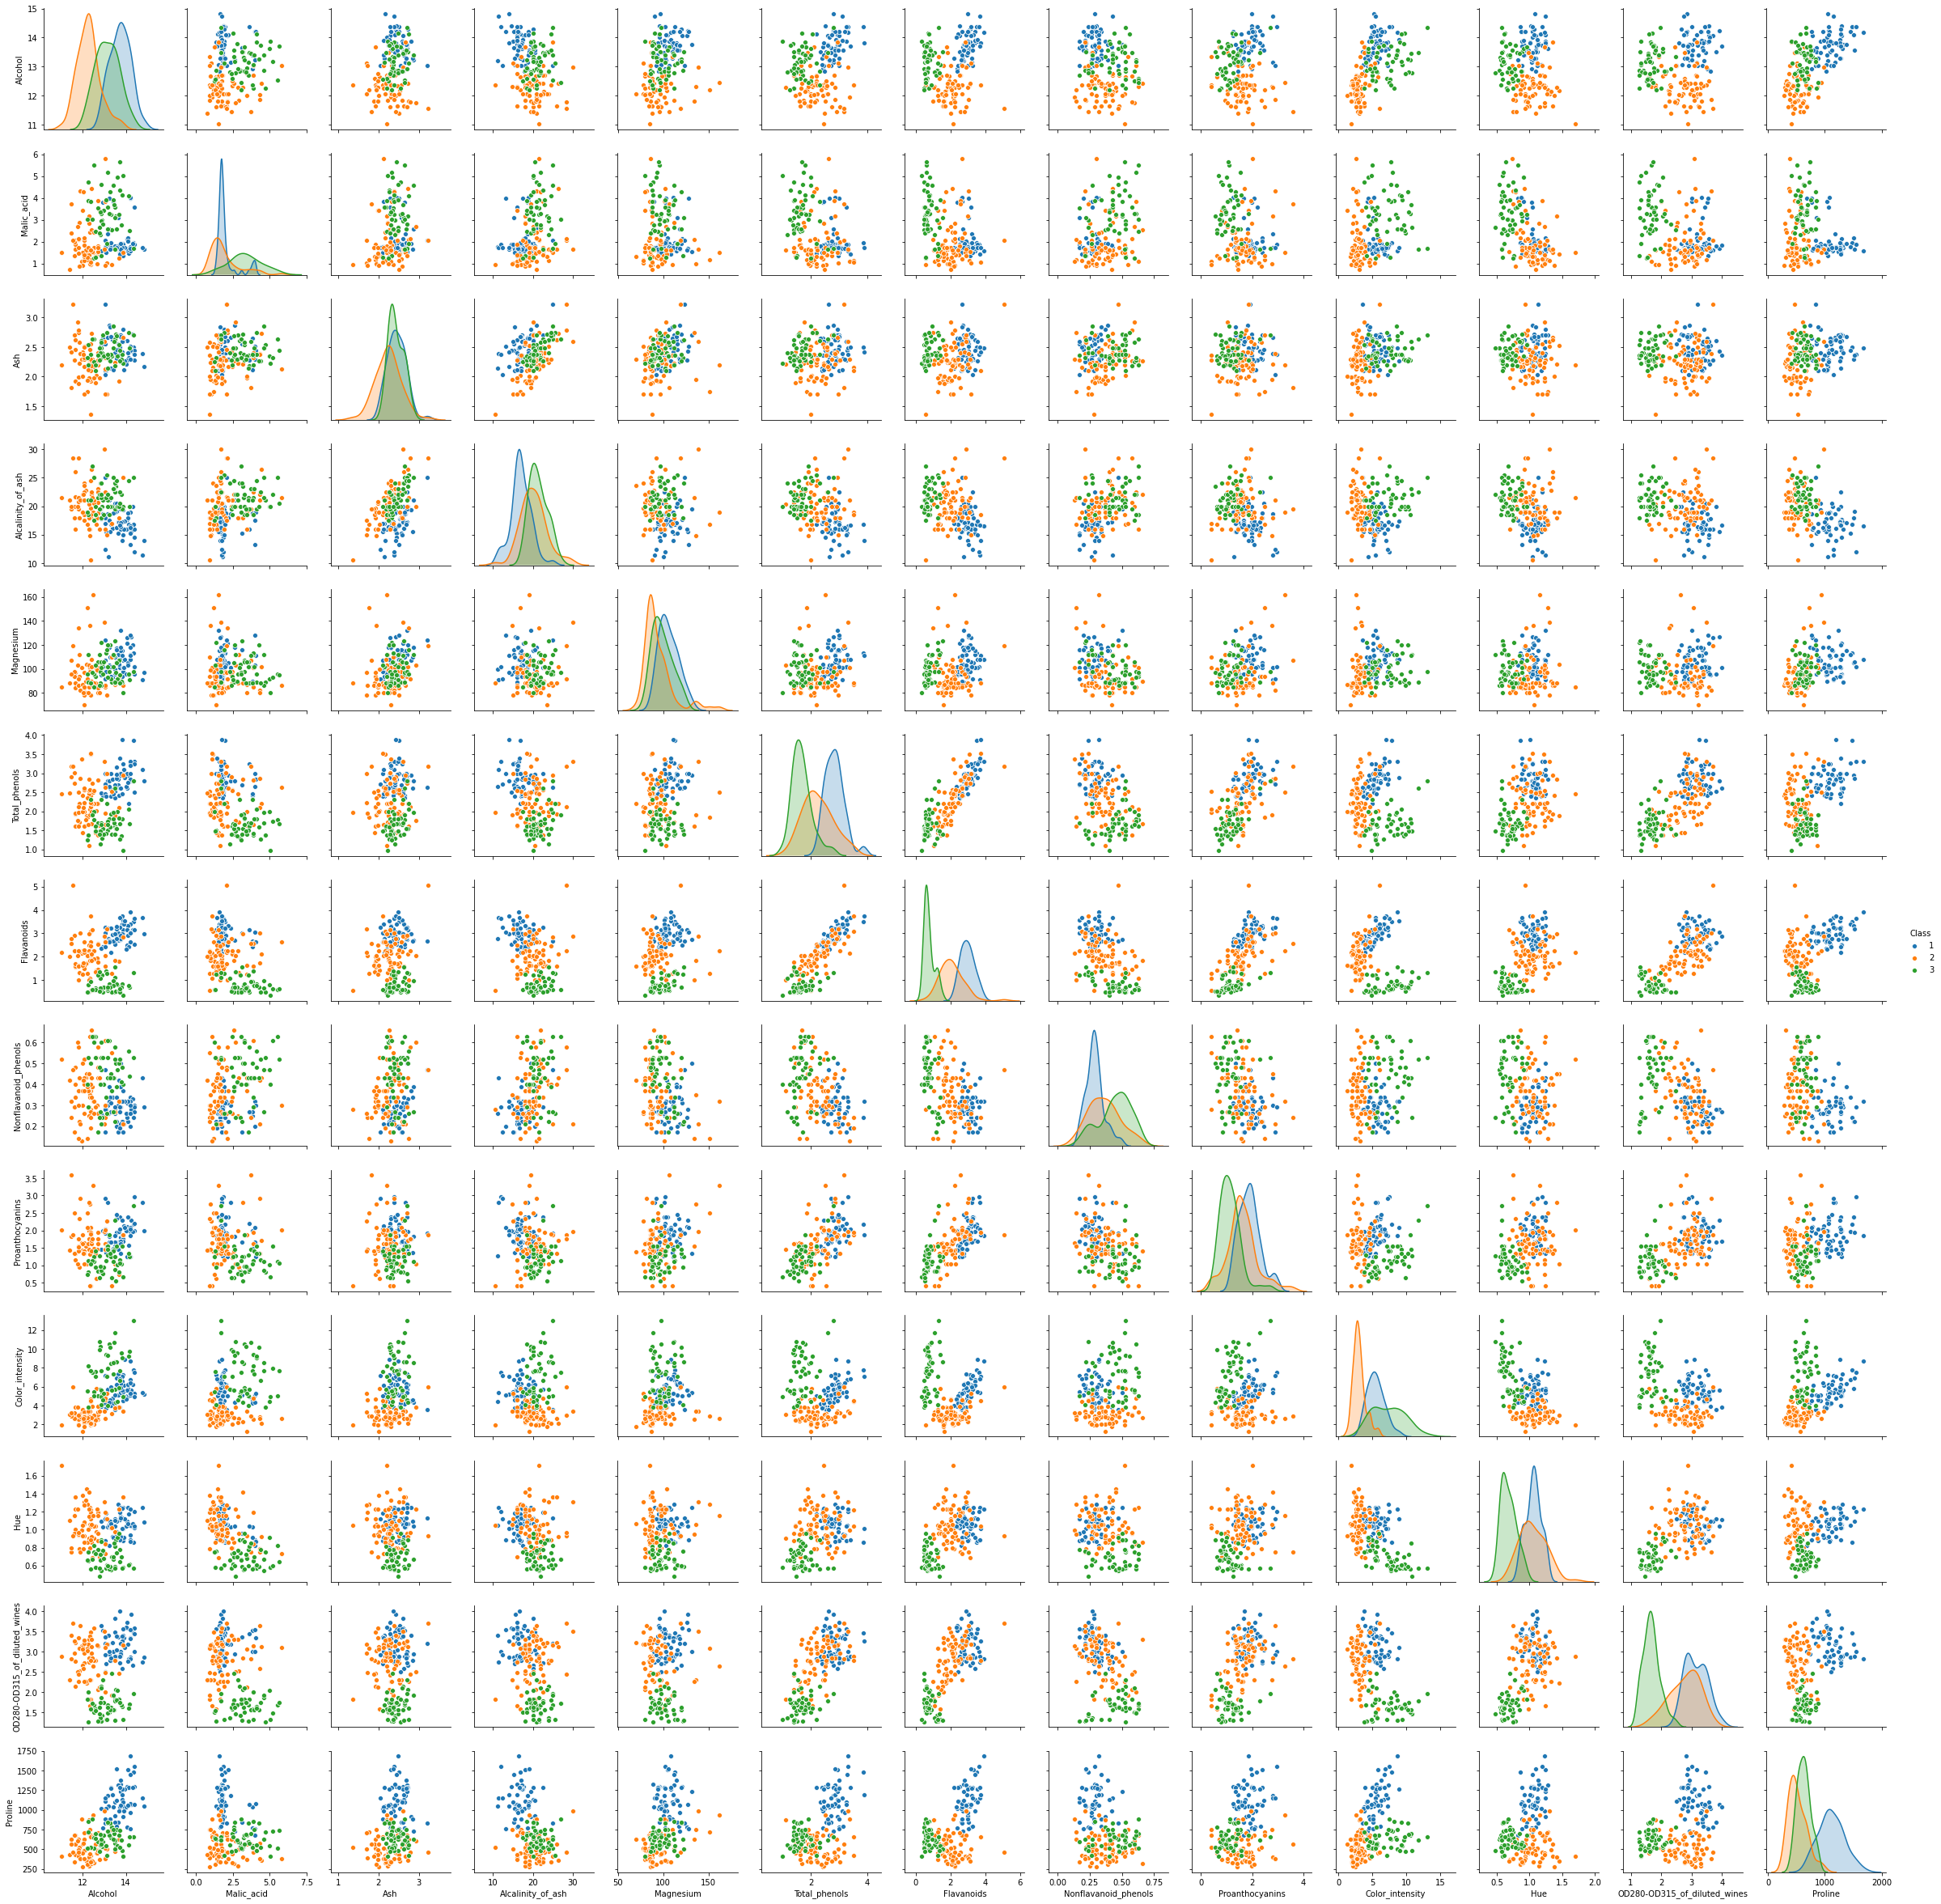

In [6]:
sns.pairplot(wine_data,hue='Class')

In [7]:
mms = MinMaxScaler()


for i in wine_data.columns[1:]:
    wine_data[i] = mms.fit_transform(wine_data[[i]])

In [9]:
wine_data

,Class,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280-OD315_of_diluted_wines,Proline
0,1,0.842105,0.191700,0.572193,0.257732,0.619565,0.627586,0.573840,0.283019,0.593060,0.372014,0.455285,0.970696,0.561341
1,1,0.571053,0.205534,0.417112,0.030928,0.326087,0.575862,0.510549,0.245283,0.274448,0.264505,0.463415,0.780220,0.550642
2,1,0.560526,0.320158,0.700535,0.412371,0.336957,0.627586,0.611814,0.320755,0.757098,0.375427,0.447154,0.695971,0.646933
3,1,0.878947,0.239130,0.609626,0.319588,0.467391,0.989655,0.664557,0.207547,0.558360,0.556314,0.308943,0.798535,0.857347
4,1,0.581579,0.365613,0.807487,0.536082,0.521739,0.627586,0.495781,0.490566,0.444795,0.259386,0.455285,0.608059,0.325963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,3,0.705263,0.970356,0.582888,0.510309,0.271739,0.241379,0.056962,0.735849,0.205047,0.547782,0.130081,0.172161,0.329529
174,3,0.623684,0.626482,0.598930,0.639175,0.347826,0.282759,0.086498,0.566038,0.315457,0.513652,0.178862,0.106227,0.336662
175,3,0.589474,0.699605,0.481283,0.484536,0.543478,0.210345,0.073840,0.566038,0.296530,0.761092,0.089431,0.106227,0.397290
176,3,0.563158,0.365613,0.540107,0.484536,0.543478,0.231034,0.071730,0.754717,0.331230,0.684300,0.097561,0.128205,0.400856


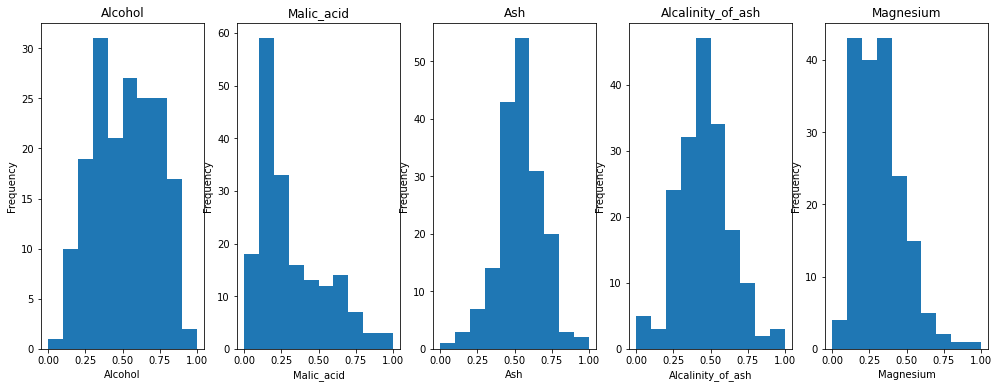

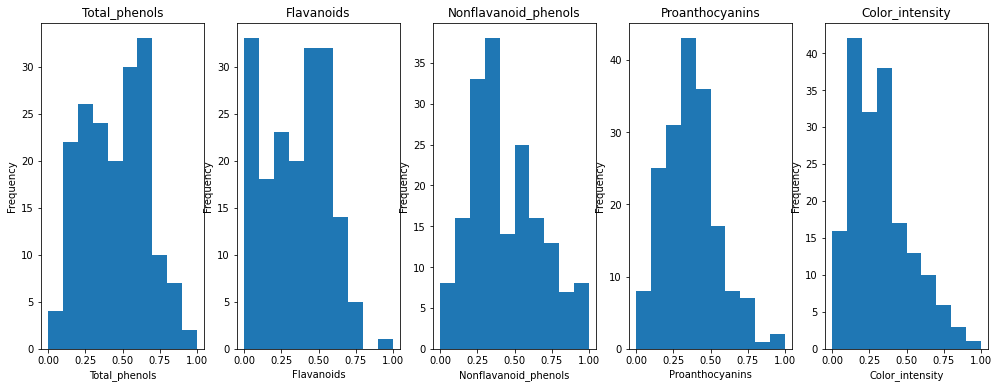

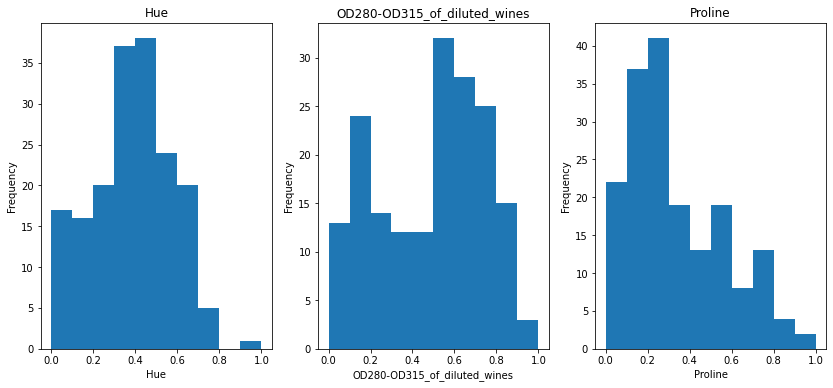

In [10]:
plt.figure(figsize=(24,6))
for i,feature in enumerate(wine_data.columns[1:6]):
    plt.subplot(1,7,i+1)
    wine_data[feature].plot(kind='hist',title=feature)
    plt.xlabel(feature)

plt.figure(figsize=(24,6))  
for i,feature in enumerate(wine_data.columns[6:11]):
    plt.subplot(1,7,i+1)
    wine_data[feature].plot(kind='hist',title=feature)
    plt.xlabel(feature)
    

plt.figure(figsize=(24,6))   
for i,feature in enumerate(wine_data.columns[11:14]):
    plt.subplot(1,5,i+1)
    wine_data[feature].plot(kind='hist',title=feature)
    plt.xlabel(feature)

In [11]:
target_dict = {1:0,2:1,3:2}
y = wine_data['Class'].map(target_dict)
y

0      0
1      0
2      0
3      0
4      0
      ..
173    2
174    2
175    2
176    2
177    2
Name: Class, Length: 178, dtype: int64

In [12]:
X = wine_data.loc[:,wine_data.columns !='Class'].values # Essential to provide the network with numpy level data points
ss = StandardScaler()
Xss = ss.fit_transform(X)
# target_dict = {1:0,2:1,3:2}
# y = wine_data['Class'].map(target_dict)
# y_cat=to_categorical(y) # creates a vectorized categorical variable
y_cat = pd.get_dummies(wine_data['Class'])

X_train, X_test, y_train, y_test = train_test_split(X,y_cat.values,test_size=.3,random_state=47)


In [13]:

K.clear_session()

model = Sequential()
model.add(Dense(6, input_shape=(13,),kernel_initializer = 'uniform', activation='softmax'))
model.add(Dense(3, activation='sigmoid'))
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.01),
              metrics=['accuracy'])

h = model.fit(X_train,y_train, batch_size=32, epochs=150,verbose=0,validation_split=0.2)

result = model.evaluate(X_test,y_test)

# print(f'Accuracy: {result[1] * 100:.4}%')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

### Solutions Model

In [14]:
K.clear_session()

model = Sequential()
model.add(Dense(5, input_shape=(13,),kernel_initializer = 'he_normal', activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=0.01),
              metrics=['accuracy'])

h = model.fit(X_train,y_train, batch_size=8, epochs=10,verbose=1,validation_split=0.2)

result = model.evaluate(X_test,y_test)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 1/13 [=>............................] - ETA: 3s - loss: 1.1084 - accuracy: 0.3750WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f9616ae15f0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and 

### Exercise 2

Since this dataset has 13 features we can only visualize pairs of features like we did in the Paired plot. We could however exploit the fact that a neural network is a function to extract 2 high level features to represent our data.

- Build a deep fully connected network with the following structure:
    - Layer 1: 8 nodes
    - Layer 2: 5 nodes
    - Layer 3: 2 nodes
    - Output : 3 nodes
- Choose activation functions, inizializations, optimizer and learning rate so that it converges to 100% accuracy within 20 epochs (not easy)
- Remember to train the model on the scaled data
- Define a Feature Funtion like we did above between the input of the 1st layer and the output of the 3rd layer
- Calculate the features and plot them on a 2-dimensional scatter plot
- Can we distinguish the 3 classes well?


In [15]:
K.clear_session()

model = Sequential()
model.add(Dense(8, input_shape=(13,),kernel_initializer = 'normal', activation='tanh'))
model.add(Dense(5, activation='tanh'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=0.01),
              metrics=['accuracy'])
model.fit(X_train,y_train, batch_size=32, epochs=20,verbose=1,validation_split=0.2)

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/4 [======>.......................] - ETA: 1s - loss: 1.1133 - accuracy: 0.2812WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f96171f5560> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and at

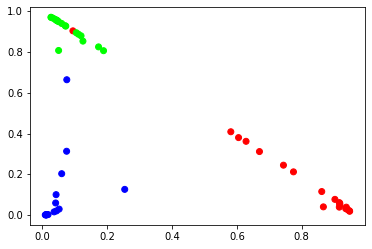

In [16]:
inp = model.layers[0].input
out = model.layers[2].output
features_function = K.function([inp],[out])
features = features_function([X_test])[0]
plt.scatter(features[:,0],features[:,1],c=y_test,cmap='coolwarm')

### Exercise 3

Keras functional API. So far we've always used the Sequential model API in Keras. However, Keras also offers a Functional API, which is much more powerful. You can find its [documentation here](https://keras.io/getting-started/functional-api-guide/). Let's see how we can leverage it.

- define an input layer called `inputs`
- define two hidden layers as before, one with 8 nodes, one with 5 nodes
- define a `second_to_last` layer with 2 nodes
- define an output layer with 3 nodes
- create a model that connect input and output
- train it and make sure that it converges
- define a function between inputs and second_to_last layer
- recalculate the features and plot them

In [39]:
K.clear_session()
inputs = keras.Input(shape=(13,))
dense = layers.Dense(8, activation='relu')(inputs)
dense_1 = layers.Dense(5, activation='relu')(dense)
# second_to_last = layers.Dense(2, activation='relu')(dense_1)
outputs = layers.Dense(3,activation='softmax')(dense_1)

model = keras.Model(inputs=inputs,outputs=outputs,name='wine_model_3')
model.summary()

model.compile(loss = keras.losses.CategoricalCrossentropy(),
              optimizer = Adam(lr=0.01),
              metrics=['accuracy'])

Model: "wine_model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 13)]              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 112       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 45        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 18        
Total params: 175
Trainable params: 175
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.fit(X_train,y_train,batch_size=64,epochs=20,validation_split=0.2)

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/2 [==============>...............] - ETA: 0s - loss: 1.0761 - accuracy: 0.4375WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f95f96055f0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and at

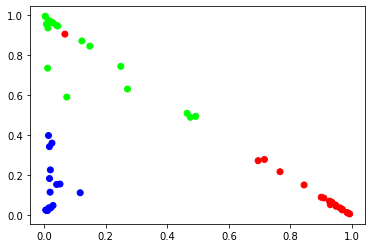

In [35]:
inp = model.layers[0].input
out = model.layers[3].output
features_function = K.function([inp],[out])
features = features_function([X_test])[0]
plt.scatter(features[:,0],features[:,1],c=y_test,cmap='coolwarm')

### Exercise 4 

Keras offers the possibility to call a function at each epoch. These are Callbacks, and their [documentation is here](https://keras.io/callbacks/). Callbacks allow us to add some neat functionality. In this exercise we'll explore a few of them.

- Split the data into train and test sets with a test_size = 0.3 and random_state=42
- Reset and recompile your model
- train the model on the train data using `validation_data=(X_test, y_test)`
- Use the `EarlyStopping` callback to stop your training if the `val_loss` doesn't improve
- Use the `ModelCheckpoint` callback to save the trained model to disk once training is finished
- Use the `TensorBoard` callback to output your training information to a `/tmp/` subdirectory
- Watch the next video for an overview of tensorboard

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X,y_cat.values,test_size=.3,random_state=42)

In [43]:
checkpointer = ModelCheckpoint(filepath = '/tmp/weights.hdf5',
                               verbose=1,
                               save_best_only=True)

# Stops fitting when network is no longer improving. 
earlystopper = EarlyStopping(monitor='val_loss',
                             min_delta=0,
                             patience=1,
                             verbose=1,
                             mode='auto')

tensorboard = TensorBoard(log_dir = '/tmp/tensorboard/')

In [44]:
K.clear_session()
inputs = keras.Input(shape=(13,))
dense = layers.Dense(8, activation='relu')(inputs)
dense_1 = layers.Dense(5, activation='relu')(dense)
# second_to_last = layers.Dense(2, activation='relu')(dense_1)
outputs = layers.Dense(3,activation='softmax')(dense_1)

model = keras.Model(inputs=inputs,outputs=outputs,name='wine_model_3')
model.summary()

model.compile(loss = keras.losses.CategoricalCrossentropy(),
              optimizer = Adam(lr=0.01),
              metrics=['accuracy'])

Model: "wine_model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 13)]              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 112       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 45        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 18        
Total params: 175
Trainable params: 175
Non-trainable params: 0
_________________________________________________________________


In [45]:
model.fit(X_train,y_train,
          batch_size=64,epochs=20,validation_split=0.2,
          callbacks = [checkpointer,earlystopper,tensorboard])


Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/2 [==============>...............] - ETA: 0s - loss: 1.1061 - accuracy: 0.3594WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f9614b0bc20> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and at

### Tensorboard
* This is a local server tool which allows us to utilize a predeveloped dashboard which allows us to explore the model. 
* Open terminal
* Run:
    * tensorboard --logdir="path_to_tensors"
* The path is specified in the TensorBoard function call in this notebook. 